# Imports

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict

# Load statics

In [2]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [3]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [4]:
# for course_num in valid_courses:

#     ### Initialize BeuatifulSoup object
#     page = G.nodes[course_num]['page']
#     soup = BeautifulSoup(page, 'html.parser')

#     ### Find <tr> that contains "Academic prerequisites"
#     search_string = "Academic prerequisites"
    
#     # Find respective label
#     label = soup.find('label', string=re.compile(search_string))
#     if label is None:
#         continue
    
#     # Get element that contains the label + prerequisites
#     parent = label.find_parent().find_parent()
    
#     # Get second <td>
#     prerequisite = parent.find_all('td')[1].text

#     # Remove whitespace and breaks (\n and \r)
#     prerequisite  = prerequisite.replace('\r', ' ')
#     prerequisite  = prerequisite.replace('\n ', '')

#     # Extract 5 digit numbers (any course number)
#     prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
#     # if course exists in graph, add edge
#     for prerequisite in prerequisites:
#         if prerequisite in G.nodes:
#             if prerequisite == course_num: 
#                 # Handle self-loops
#                 pass
#             else:
#                 G.add_edge(prerequisite, course_num)

In [5]:
for course_num in valid_courses:

    # Initialize BeautifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    # Define the search pattern to match both "Academic prerequisites" and "Mandatory prerequisites"
    search_pattern = r"(Academic prerequisites|Mandatory Prerequisites)"
    
    # Find the label element that matches the pattern
    label = soup.find('label', string=re.compile(search_pattern))
    if label is None:
        continue  # Skip if no label is found
    
    # Get the parent element that contains the label and prerequisites
    parent = label.find_parent().find_parent()
    
    # Get the second <td> (assuming it contains the prerequisites text)
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and line breaks
    prerequisite = prerequisite.replace('\r', ' ').replace('\n', ' ')

    # Extract 5-digit course numbers
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # Add edges to the graph for valid prerequisites
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite != course_num:  # Skip self-loops
                G.add_edge(prerequisite, course_num)


## Add text attributes

In [6]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

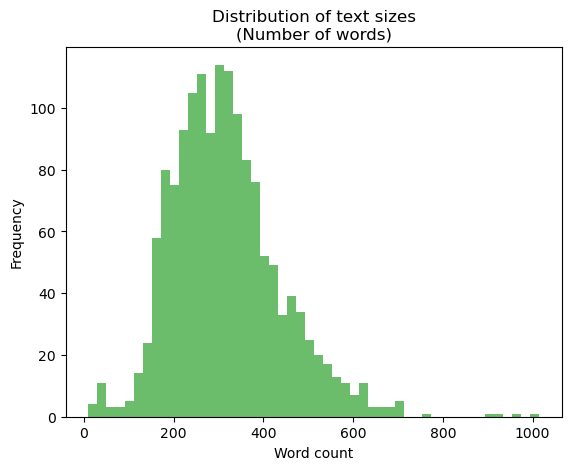

In [7]:
# plot distribution of text sizes
text_sizes = [G.nodes[node]['word_count'] for node in G.nodes]
plt.hist(text_sizes, bins=50, color='C2', alpha=0.7)
plt.title('Distribution of text sizes\n(Number of words)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Get evaluations and grades

In [8]:
# Evaluations
with open('eval_scores.json') as f:
    eval_scores = json.load(f)

# Grades
with open('grade_scores.json') as f:
    grade_scores = json.load(f)

In [9]:
# Apply evaluation and grade attributes
for course_num in grade_scores:
    G.nodes[course_num]['eval_scores'] = eval_scores[course_num]
    G.nodes[course_num]['grade_scores'] = grade_scores[course_num]
    
# Remove nodes from G that do not have evaluation scores
G = G.subgraph([node for node in G.nodes if 'eval_scores' in G.nodes[node]])
# Remove nodes from G with empty evaluation scores
G = G.subgraph([node for node in G.nodes if G.nodes[node]['eval_scores']])

In [10]:
G.nodes['02805']

{'course_num': '02805',
 'page': '<!DOCTYPE html>\r\n<html>\r\n<head>\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge" />\r\n    <meta charset="utf-8" />\r\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\r\n    \r\n    <title>\r\n    02805 Social graphs and interactions \r\n</title>\r\n    <link href="/bundles_css_general?v=mCt0xLH6ZVm097AMT4IZXI_8YhGCBjBIv-CzzPZWduw1" rel="stylesheet"/>\r\n\r\n    <script src="/bundles_js_general?v=m944kgjFG7-r2HFwxi7Q_xDuvGXt8MWkcxYxVH_TSmE1"></script>\r\n\r\n    \r\n\r\n\r\n    <script>\r\n        $(function () {\r\n            $("[data-open-dialog]").on(\'click touchstart\', function () {\r\n                var me = $(this);\r\n                var bs = $("#" + me.data("open-dialog"));\r\n                bs.modal({ show: true, backdrop: true });\r\n            });\r\n        });\r\n\r\n        function getCookie(cname) {\r\n            var name = cname + "=";\r\n            var decodedCookie = decodeURIComponen

# Degree distribution

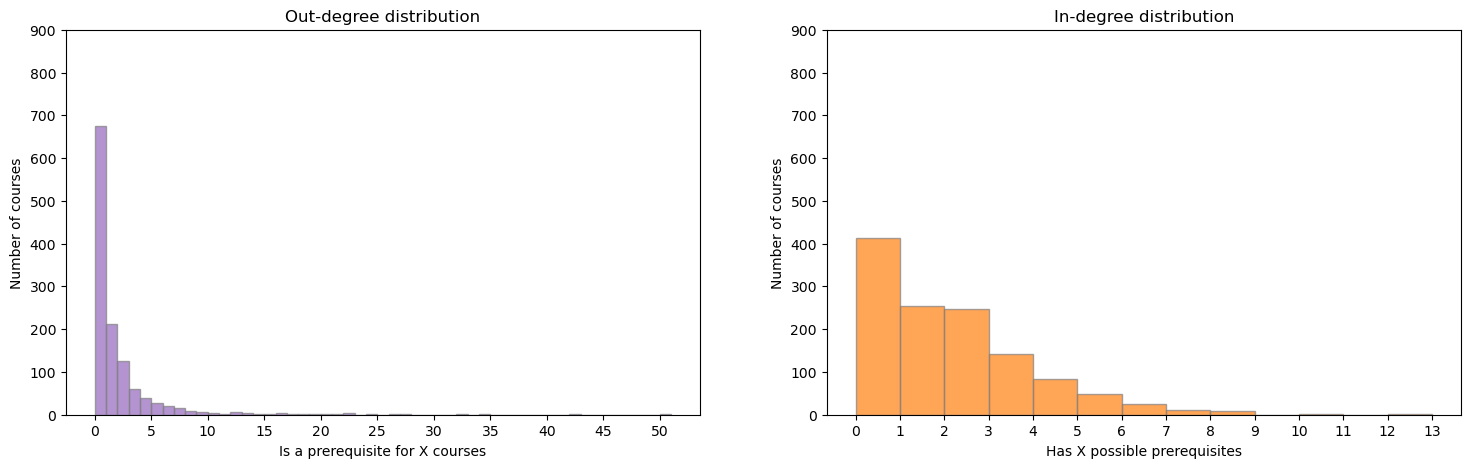

In [11]:
# Calculate in- and out-degrees. Show histogram
in_degrees = [G.in_degree(n) for n in G.nodes]
out_degrees = [G.out_degree(n) for n in G.nodes]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
axs[0].set_ylim(0, 900)
axs[0].hist(out_degrees, bins=range(min(out_degrees), max(out_degrees) + 2), color='C4', alpha=0.7, edgecolor='grey')
axs[0].set_xlabel('Is a prerequisite for X courses')
axs[0].set_ylabel('Number of courses')
axs[0].set_title('Out-degree distribution')
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0].xaxis.set_major_locator(plt.MultipleLocator(5))

axs[1].set_ylim(0, 900)
axs[1].hist(in_degrees, bins=range(min(in_degrees), max(in_degrees) + 2), color='C1', alpha=0.7, edgecolor='grey')

axs[1].set_xlabel('Has X possible prerequisites')
axs[1].set_ylabel('Number of courses')
axs[1].set_title('In-degree distribution')
axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(1))

plt.show()

# Plotting

## Test partitionings

In [12]:
import networkx as nx
from collections import Counter, defaultdict
import random

def overlapping_label_propagation(graph, max_size, max_iterations=100):
    """
    Overlapping Label Propagation Algorithm with size constraints.

    Parameters:
        graph (nx.Graph): The input graph.
        max_size (int): The maximum allowable size for a community.
        max_iterations (int): Maximum number of iterations to run the algorithm.

    Returns:
        dict: A dictionary where keys are community indices (starting from 0) and values are lists of nodes.
    """
    # Initialize each node with its own unique label as a set
    labels = {node: {node} for node in graph.nodes}
    
    for iteration in range(max_iterations):
        changes = False
        
        # Randomize node order to reduce bias
        nodes = list(graph.nodes)
        random.shuffle(nodes)
        
        for node in nodes:
            # Collect all labels from neighbors
            neighbor_labels = []
            for neighbor in graph.neighbors(node):
                neighbor_labels.extend(labels[neighbor])  # Collect labels of neighbors
            
            # Count the frequency of each label in the neighborhood
            label_counts = Counter(neighbor_labels)
            
            # Sort labels by frequency (descending) and resolve ties randomly
            sorted_labels = sorted(label_counts.items(), key=lambda x: (-x[1], random.random()))
            
            # Add labels while respecting size constraints
            current_labels = labels[node]
            for label, _ in sorted_labels:
                community_size = sum(1 for n in graph.nodes if label in labels[n])
                if community_size < max_size and label not in current_labels:
                    current_labels.add(label)
                    changes = True
            
        # Stop if no labels were changed
        if not changes:
            break
    
    # Create a community dictionary with sequential indices
    community_dict = defaultdict(list)
    label_to_index = {}  # Map original labels to indices
    current_index = 0
    
    for node, node_labels in labels.items():
        for label in node_labels:
            if label not in label_to_index:
                label_to_index[label] = current_index
                current_index += 1
            community_dict[label_to_index[label]].append(node)
    
    return dict(community_dict)



In [13]:
def heuristic_pm_2(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Predecessors and the predecessors of predecessors
    3. Successors and the successors of successors 
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add predecessors and their predecessors
        for pred in graph.predecessors(node):
            community.add(pred)
            community.update(graph.predecessors(pred))
        
        # Add successors and their successors
        for succ in graph.successors(node):
            community.add(succ)
            community.update(graph.successors(succ))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 15 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 15}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)
    
    # replace nodes with indeces
    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


def heuristic_pm_1(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Immediate predecessors
    3. Immediate successors
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add immediate predecessors
        community.update(graph.predecessors(node))
        
        # Add immediate successors
        community.update(graph.successors(node))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 9 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 9}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)

    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


In [14]:
# Method 1 - Ordinary label propagation
from networkx.algorithms.community import label_propagation_communities
H = G.to_undirected()
communities = label_propagation_communities(H)

In [15]:
# Method 2 - Overlapping label propagation with size constraints
H = G.to_undirected()
communities = overlapping_label_propagation(H, 6)

In [16]:
# Method 3 - Overlapping label propagation with size constraints and degree filtering
H = G.to_undirected()
for node in G.nodes:
    if G.out_degree(node) > 10:
        H.remove_node(node)  
communities = overlapping_label_propagation(H, 6)

In [17]:
# Method 4 - Heuristic ± 1 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_1(H)

In [18]:
# Method 5 - Heuristic ± 2 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_2(H)

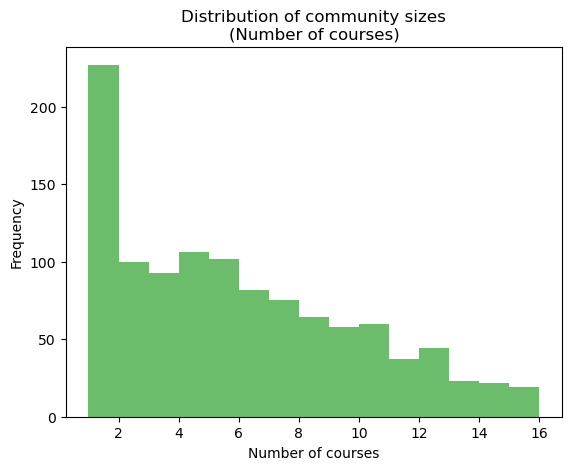

In [19]:
# plot distribution of value sizes
value_sizes = [len(communities[c]) for c in communities]
plt.hist(value_sizes, bins=range(min(value_sizes), max(value_sizes) + 2), color='C2', alpha=0.7)
plt.title('Distribution of community sizes\n(Number of courses)')
plt.xlabel('Number of courses')
plt.ylabel('Frequency')
plt.show()

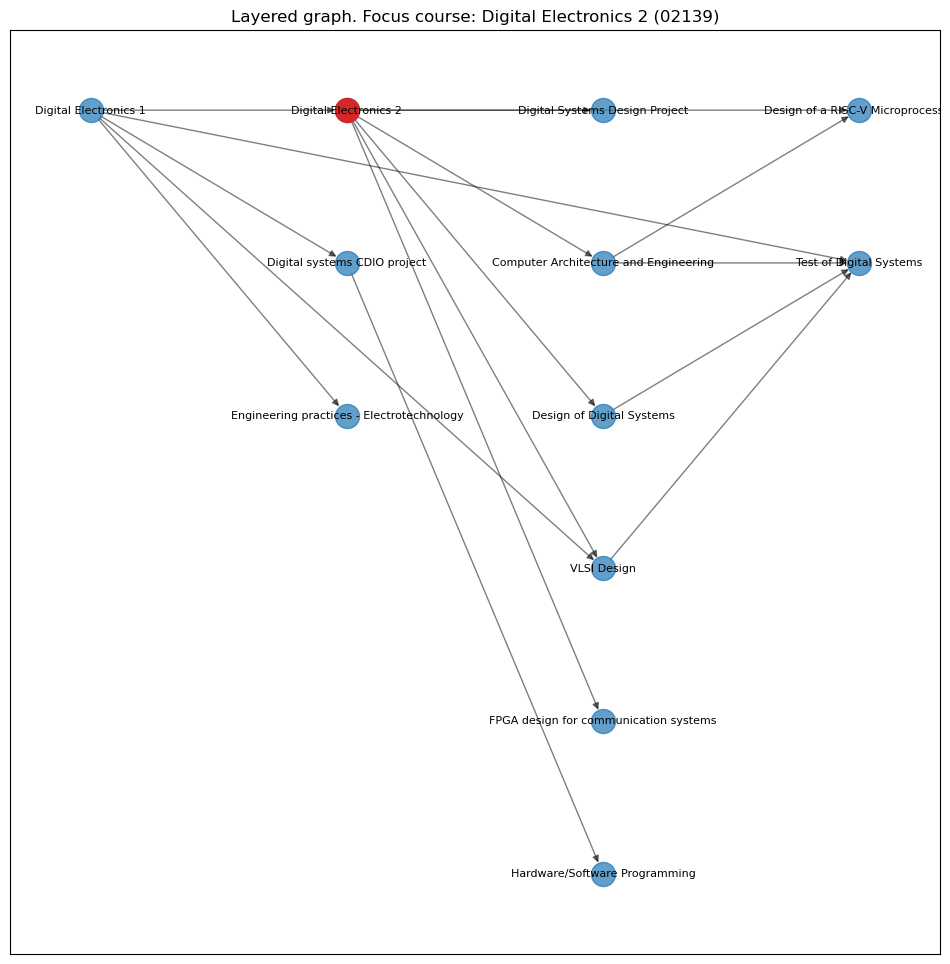

In [20]:
def plot_depth_based_layered_graph(community, graph):
    """
    Plot a layered graph where nodes are placed in layers based on depth
    from the root nodes in the directed subgraph.
    Dynamically reassigns nodes to fix layering violations.
    """
    # Create a directed subgraph from the community
    subgraph = graph.subgraph(community)
    
    # Ensure all community nodes are in the subgraph
    subgraph_nodes = set(subgraph.nodes)
    community = [node for node in community if node in subgraph_nodes]
    
    # Identify root nodes (nodes with in-degree 0)
    roots = [node for node in community if subgraph.in_degree(node) == 0]
    
    # Initialize layers, visited set, and node-to-layer mapping
    layers = defaultdict(list)
    node_to_layer = {}
    visited = set()
    
    # Assign layers iteratively
    def assign_layer(node, current_layer):
        # If the node is already visited, reassign it to a deeper layer if needed
        if node in visited:
            existing_layer = node_to_layer[node]
            if existing_layer < current_layer:
                # Move the node to the current deeper layer
                if node in layers[existing_layer]:
                    layers[existing_layer].remove(node)
                layers[current_layer].append(node)
                node_to_layer[node] = current_layer
            return
        
        # Add the node to the current layer
        layers[current_layer].append(node)
        node_to_layer[node] = current_layer
        visited.add(node)
        
        # Process successors
        for successor in subgraph.successors(node):
            assign_layer(successor, current_layer + 1)
    
    # Assign layers starting from each root
    for root in roots:
        assign_layer(root, 0)
    
    # Ensure layering is consistent by reprocessing predecessors
    for node in community:
        # Skip nodes not yet assigned a layer
        if node not in node_to_layer:
            continue
        
        node_layer = node_to_layer[node]
        for predecessor in subgraph.predecessors(node):
            predecessor_layer = node_to_layer.get(predecessor, -1)
            if predecessor_layer >= node_layer:
                # Move the node to a deeper layer
                if node in layers[node_layer]:
                    layers[node_layer].remove(node)
                new_layer = predecessor_layer + 1
                layers[new_layer].append(node)
                node_to_layer[node] = new_layer
    
    # Assign positions for all nodes in the subgraph
    pos = {}
    for i, (layer, nodes) in enumerate(sorted(layers.items())):
        for j, node in enumerate(nodes):
            pos[node] = (i, -j)
    
    # Check for unpositioned nodes and add them to a separate layer
    unpositioned_nodes = [node for node in subgraph.nodes if node not in pos]
    if unpositioned_nodes:
        last_layer = max(pos.values(), default=(0, 0))[0] + 1
        for j, node in enumerate(unpositioned_nodes):
            pos[node] = (last_layer, -j)
    
    # Determine the center node based on degree
    center_node = max(subgraph.nodes, key=lambda x: subgraph.degree(x))
    
    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(subgraph, pos, node_size=300, node_color='C0', alpha=0.7)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
    labels = {node: graph.nodes[node].get('course_title', str(node)) for node in subgraph.nodes}
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=8)
    
    # Highlight the center node in red
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[center_node], node_size=300, node_color='C3')
    
    plt.title(f"Layered graph. Focus course: {graph.nodes[center_node].get('course_title', str(center_node))} ({center_node})")
    plt.show()

plot_depth_based_layered_graph(communities[24], G)

### Department only

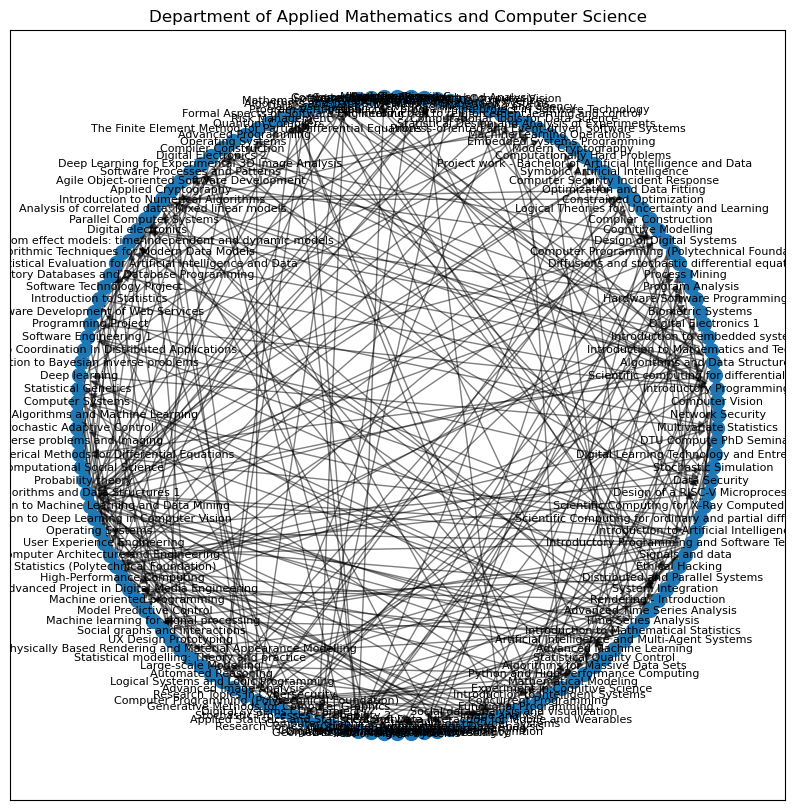

In [21]:
# plot subgraph of G, where department is X
department = '02'
subgraph = G.subgraph([node for node in G.nodes if G.nodes[node]['department'] == department])
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color=department_colors[department])
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
# labels = course_title
nx.draw_networkx_labels(subgraph, pos, labels={node: G.nodes[node]['course_title'] for node in subgraph.nodes}, font_size=8)
plt.title(department_names[department])
plt.show()

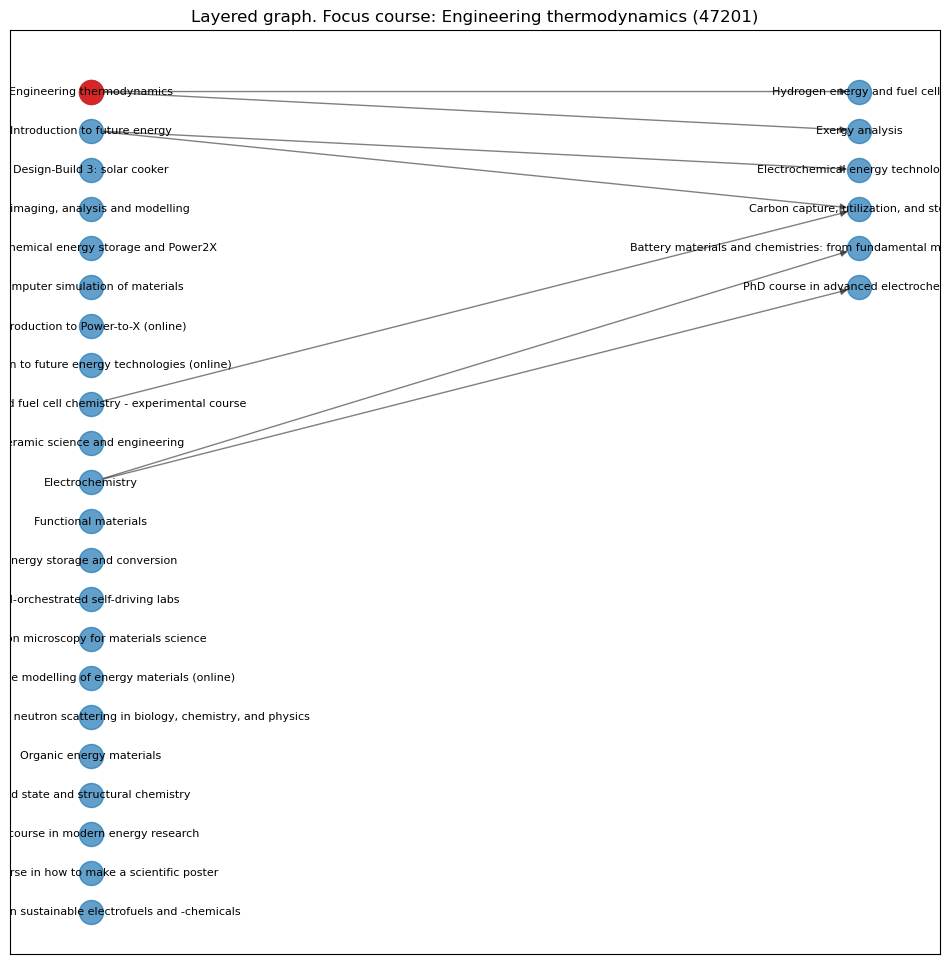

In [33]:
# get all courses from department
department = '47'
courses = [node for node in G.nodes if G.nodes[node]['department'] == department]

plot_depth_based_layered_graph(courses, G)

# Summarize communities

In [23]:
class CommunitiesSummary():
    def __init__(self, graph, communities):
        self.graph = graph
        self.communities = communities
    
    # Number of communities
    def __len__(self):
        return len(self.communities)
    
    # Average grade
    def avg_grade(self, community_index):
        grades = []
        for course in self.communities[community_index]:
            grade = self.graph.nodes[course]['grade_scores'][2]
            
            # Only add if the course uses the 7-scale grading system
            if grade is not None:
                grades.append(grade)
        
        # Return None if no grades were found
        if len(grades) == 0:
            return None
        
        # Return the average grade
        return sum(grades) / len(grades)
    
    # Average pass rate
    def avg_pass_rate(self, community_index):
        pass_rates = []
        for course in self.communities[community_index]:
            grade_scores = self.graph.nodes[course]['grade_scores']
            pass_rates.append(grade_scores[1] / grade_scores[0])
       
        # Return average pass rate 
        return sum(pass_rates) / len(pass_rates)
    
    # Average evaluation score
    def avg_evals(self, community_index):
        
        all_evals = []
        for i in range(6):
            evals = []
            for course in self.communities[community_index]:
                eval_score = self.graph.nodes[course]['eval_scores'][i]
                evals.append(eval_score)
            all_evals.append(sum(evals)/len(evals))
        
        return all_evals
    
    # Get single community stats
    def __getitem__(self, index):
        community = self.communities[index]
        return {
            'index': index,
            'size': len(community),
            'courses': community,
            'courses_titles': [self.graph.nodes[course]['course_title'] for course in community],
            'avg_grade': self.avg_grade(index),
            'avg_pass_rate': self.avg_pass_rate(index),
            'avg_evals': self.avg_evals(index),
            'all_text': ' '.join([self.graph.nodes[course]['course_text'] for course in community])
        }
        
    # Get all communities that includes course
    def get_communities(self, course):
        return [index for index, community in self.communities.items() if course in community]
   
        
COM = CommunitiesSummary(G, communities)

In [25]:
includes_course = COM.get_communities('02289')
print("Size:", len(includes_course))
for i in includes_course:
    display(COM[i])
    print()

Size: 2


{'index': 63,
 'size': 11,
 'courses': ['02002',
  '01019',
  '01017',
  '02326',
  '01904',
  '02312',
  '02289',
  '02100',
  '02003',
  '02105',
  '02110'],
 'courses_titles': ['Computer Programming (Polytechnical Foundation)',
  'Discrete Mathematics',
  'Discrete Mathematics',
  'Algorithms and Data Structures',
  'Discrete mathematics',
  'Introductory Programming',
  'Algorithmic Techniques for Modern Data Models',
  'Introductory Programming and Software Technology',
  'Computer Programming (Polytechnical Foundation)',
  'Algorithms and Data Structures 1',
  'Algorithms and Data Structures 2'],
 'avg_grade': 6.036363636363635,
 'avg_pass_rate': 0.809958784970246,
 'avg_evals': [3.8738185901731104,
  4.005541233936528,
  3.484069194807059,
  3.319530405606912,
  3.573239826957371,
  3.304123092268317],
 'all_text': 'The main objective is to provide students with the foundation for computational thinking that is needed in later courses and when working as an engineer. Computer pr

{'index': 70,
 'size': 13,
 'courses': ['02346',
  '02326',
  '02170',
  '01904',
  '02312',
  '02249',
  '42137',
  '02289',
  '02282',
  '42577',
  '02110',
  '02335',
  '02332'],
 'courses_titles': ['Distributed and Parallel Systems',
  'Algorithms and Data Structures',
  'Database Systems',
  'Discrete mathematics',
  'Introductory Programming',
  'Computationally Hard Problems',
  'Optimization using metaheuristics',
  'Algorithmic Techniques for Modern Data Models',
  'Algorithms for Massive Data Sets',
  'Introduction to Business Analytics',
  'Algorithms and Data Structures 2',
  'Operating Systems',
  'Compiler Construction'],
 'avg_grade': 6.184615384615385,
 'avg_pass_rate': 0.8512112803446372,
 'avg_evals': [3.9164576405965565,
  4.046736254418214,
  3.6094574441340246,
  3.456362755360952,
  3.7285769502536157,
  3.367763795920065],
 'all_text': 'The course provides a broad introduction to distributed and parallel programming with a focus on practically applicable knowledg